In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller1 import player_controller
from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [6]:
def run_algorithm_a(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1):
	"""
	Runs Genetic Algorithm A with the provided environment and parameters.

	Parameters:
	- env: Evoman Environment instance.
	- npopulation: Population size.
	- gens: Number of generations.
	- mutation_rate: Mutation rate.
	- dom_u: Upper bound for gene values.
	- dom_l: Lower bound for gene values.
	- elitism_count: Number of elites to preserve.

	Returns:
	- history_mean: List of mean fitness per generation.
	- history_max: List of max fitness per generation.
	- best_solution: Best solution found.
	"""
	n_hidden_neurons_1 = 10
	n_hidden_neurons_2 = 5

	n_vars = (
		(env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
		(n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
		(n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
	)
	# Run the simulation and return the fitness
	def simulate(x):
		f, _, _, _ = env.play(pcont=x)
		return f

	# Evaluate the current population
	def evaluate(population):
		return np.array([simulate(individual) for individual in population])

	# Tournament Selection
	def tournament_selection(population, fitness, k=5):
		selected = []
		for _ in range(len(population)):
			contenders = np.random.choice(len(population), k, replace=False)
			winner = contenders[np.argmax(fitness[contenders])]
			selected.append(population[winner])
		return np.array(selected)

	# Uniform Crossover
	def crossover(parent1, parent2):
		mask = np.random.rand(n_vars) < 0.5
		child1 = np.where(mask, parent1, parent2)
		child2 = np.where(mask, parent2, parent1)
		return child1, child2

	# Gaussian Mutation
	def mutate(child):
		for i in range(n_vars):
			if np.random.rand() < mutation_rate:
				child[i] += np.random.normal(0, 0.1)
				child[i] = np.clip(child[i], dom_l, dom_u)
		return child

	# Initialize population
	population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
	fitness = evaluate(population)

	# Record fitness over generations
	history_mean = []
	history_max = []

	# Genetic Algorithm Loop
	for generation in range(1, gens + 1):
		# Selection
		selected = tournament_selection(population, fitness)

		# Crossover
		offspring = []
		for i in range(0, npopulation, 2):
			parent1, parent2 = selected[i], selected[i+1]
			child1, child2 = crossover(parent1, parent2)
			offspring.extend([child1, child2])
		offspring = np.array(offspring)[:npopulation]

		# Mutation
		offspring = np.array([mutate(child) for child in offspring])

		# Evaluation
		offspring_fitness = evaluate(offspring)

		# Replacement: Elitism (keep the best individual) (Could maybe change this)
		best_idx = np.argmax(fitness)
		worst_idx = np.argmin(offspring_fitness)
		if fitness[best_idx] > offspring_fitness[worst_idx]:
			offspring[worst_idx] = population[best_idx]
			offspring_fitness[worst_idx] = fitness[best_idx]
		
		population, fitness = offspring, offspring_fitness

		# Record statistics
		history_mean.append(np.mean(fitness))
		history_max.append(np.max(fitness))

		# Logging
		print(f'Generation {generation}: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

	# Get best solution
	best_idx = np.argmax(fitness)
	best_solution = population[best_idx]

	return history_mean, history_max, best_solution

In [12]:
def run_algorithm_b(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1, elitism_count=2, share_alpha=0.1, share_sigma=0.2):
	"""
	Runs Genetic Algorithm B (GA with Fitness Sharing for diversity maintenance).

	Parameters:
	- env: Evoman Environment instance.
	- npopulation: Population size.
	- gens: Number of generations.
	- mutation_rate: Mutation rate.
	- dom_u: Upper bound for gene values.
	- dom_l: Lower bound for gene values.
	- elitism_count: Number of elites to preserve.
	- share_alpha: Sharing coefficient.
	- share_sigma: Sharing radius.

	Returns:
	- history_mean: List of mean fitness per generation.
	- history_max: List of max fitness per generation.
	- best_solution: Best solution found.
	"""

	n_hidden_neurons_1 = 10
	n_hidden_neurons_2 = 5

	n_vars = (
		(env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
		(n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
		(n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
	)

	# Run the simulation and return the fitness
	def simulate(x):
		f, _, _, _ = env.play(pcont=x)
		return f

	# Evaluate the current population
	def evaluate(population):
		return np.array([simulate(individual) for individual in population])

	# Tournament Selection
	def tournament_selection(population, fitness, k=5):
		selected = []
		for _ in range(len(population)):
			contenders = np.random.choice(len(population), k, replace=False)
			winner = contenders[np.argmax(fitness[contenders])]
			selected.append(population[winner])
		return np.array(selected)

	# Two-Point Crossover
	def two_point_crossover(parent1, parent2):
		point1 = np.random.randint(0, n_vars)
		point2 = np.random.randint(point1, n_vars)
		child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
		child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
		return child1, child2

	# Gaussian Mutation
	def mutate(child):
		for i in range(n_vars):
			if np.random.rand() < mutation_rate:
				child[i] += np.random.normal(0, 0.1)
				child[i] = np.clip(child[i], dom_l, dom_u)
		return child

	# Fitness Sharing
	def fitness_sharing(population, fitness, alpha, sigma):
		"""
		Adjusts fitness based on similarity using fitness sharing.

		Parameters:
		- population: Current population.
		- fitness: Original fitness values.
		- alpha: Sharing coefficient.
		- sigma: Sharing radius.

		Returns:
		- shared_fitness: Adjusted fitness values.
		"""
		shared_fitness = np.copy(fitness)
		npop = population.shape[0]
		for i in range(npop):
			for j in range(npop):
				if i != j:
					distance = np.linalg.norm(population[i] - population[j])
					if distance < sigma:
						shared_fitness[i] -= alpha * (1 - distance / sigma)
		# Ensure that fitness doesn't become negative
		shared_fitness = np.maximum(shared_fitness, 0)
		return shared_fitness

	# Initialize population
	population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
	fitness = evaluate(population)

	# Apply Fitness Sharing
	fitness = fitness_sharing(population, fitness, share_alpha, share_sigma)

	# Record fitness over generations
	history_mean = []
	history_max = []

	# Genetic Algorithm Loop
	for generation in range(1, gens + 1):
		# Selection
		selected = tournament_selection(population, fitness)

		# Crossover
		offspring = []
		for i in range(0, npopulation, 2):
			parent1, parent2 = selected[i], selected[i+1]
			child1, child2 = two_point_crossover(parent1, parent2)
			offspring.extend([child1, child2])
		offspring = np.array(offspring)[:npopulation]

		# Mutation
		offspring = np.array([mutate(child) for child in offspring])

		# Evaluation
		offspring_fitness = evaluate(offspring)

		# Apply Fitness Sharing
		offspring_fitness = fitness_sharing(offspring, offspring_fitness, share_alpha, share_sigma)

		# Elitism: Preserve top elites
		if elitism_count > 0:
			sorted_indices = np.argsort(fitness)[::-1]
			elites = population[sorted_indices[:elitism_count]]
			elite_fitness = fitness[sorted_indices[:elitism_count]]

			# Replace worst offspring with elites
			sorted_offspring_indices = np.argsort(offspring_fitness)
			offspring[sorted_offspring_indices[:elitism_count]] = elites
			offspring_fitness[sorted_offspring_indices[:elitism_count]] = elite_fitness

		population, fitness = offspring, offspring_fitness

		# Record statistics
		history_mean.append(np.mean(fitness))
		history_max.append(np.max(fitness))

		# Logging
		print(f'Generation {generation}: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

	# Get best solution
	best_idx = np.argmax(fitness)
	best_solution = population[best_idx]

	return history_mean, history_max, best_solution

In [10]:
# Experiment Parameters
enemy = 6
num_runs = 2  			# Change to 10 for full experiment
npopulation = 200
gens = 10 				# Change to 30 for full experiment
mutation_rate = 0.05
dom_u, dom_l = 1, -1
elitism_count_a = 1  	# For Algorithm A
elitism_count_b = 2  	# For Algorithm B
n_hidden1 = 10
n_hidden2 = 5


# Initialize data storage
results = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Generation': [],
    'Mean Fitness': [],
    'Max Fitness': [],
    'Best Solution': []
}

best_solutions = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Best Solution': []
}

In [14]:
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5

for run in range(1, num_runs + 1):
	print(f"Run {run}/{num_runs}")
	
	# Define experiment names for Algorithm A and B
	experiment_name_a = f'optimization_test_a_run_{run}'
	experiment_name_b = f'optimization_test_b_run_{run}'
	
	# Create directories for Algorithm A and B
	os.makedirs(experiment_name_a, exist_ok=True)
	os.makedirs(experiment_name_b, exist_ok=True)
	
	# Initialize Environment for Algorithm A
	env_a = Environment(
		experiment_name=experiment_name_a,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
		enemymode="static",
		level=2,
		speed="fastest",
		visuals=False
	)
	
	# Run Algorithm A
	mean_a, max_a, best_a = run_algorithm_a(
		env=env_a,
		npopulation=npopulation,
		gens=gens,
		mutation_rate=mutation_rate,
		dom_u=dom_u,
		dom_l=dom_l
	)
	
	# Record data for Algorithm A
	for gen in range(1, gens + 1):
		results['Algorithm'].append('A')
		results['Enemy'].append(enemy)
		results['Run'].append(run)
		results['Generation'].append(gen)
		results['Mean Fitness'].append(mean_a[gen - 1])
		results['Max Fitness'].append(max_a[gen - 1])
		results['Best Solution'].append(best_a)
	
	best_solutions['Algorithm'].append('A')
	best_solutions['Enemy'].append(enemy)
	best_solutions['Run'].append(run)
	best_solutions['Best Solution'].append(best_a)
	
	# Initialize Environment for Algorithm B
	env_b = Environment(
		experiment_name=experiment_name_b,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
		enemymode="static",
		level=2,
		speed="fastest",
		visuals=False
	)
	
	# Run Algorithm B
	mean_b, max_b, best_b = run_algorithm_b(
		env=env_b,
		npopulation=npopulation,
		gens=gens,
		mutation_rate=mutation_rate,
		dom_u=dom_u,
		dom_l=dom_l,
		elitism_count=elitism_count_b
	)
	
	# Record data for Algorithm B
	for gen in range(1, gens + 1):
		results['Algorithm'].append('B')
		results['Enemy'].append(enemy)
		results['Run'].append(run)
		results['Generation'].append(gen)
		results['Mean Fitness'].append(mean_b[gen - 1])
		results['Max Fitness'].append(max_b[gen - 1])
		results['Best Solution'].append(best_b)
	
	best_solutions['Algorithm'].append('B')
	best_solutions['Enemy'].append(enemy)
	best_solutions['Run'].append(run)
	best_solutions['Best Solution'].append(best_b)


Run 1/2

MESSAGE: Pygame initialized for simulation.
Generation 1: Best Fitness = 39.4825, Mean Fitness = 1.4756
Generation 2: Best Fitness = 39.4825, Mean Fitness = 5.6278
Generation 3: Best Fitness = 39.4825, Mean Fitness = 9.9536
Generation 4: Best Fitness = 39.4825, Mean Fitness = 12.6714
Generation 5: Best Fitness = 48.3869, Mean Fitness = 15.2781
Generation 6: Best Fitness = 75.2162, Mean Fitness = 18.2496
Generation 7: Best Fitness = 75.2162, Mean Fitness = 17.8363
Generation 8: Best Fitness = 75.2162, Mean Fitness = 17.0165
Generation 9: Best Fitness = 75.2162, Mean Fitness = 17.7206
Generation 10: Best Fitness = 75.2162, Mean Fitness = 19.0804

MESSAGE: Pygame initialized for simulation.
Generation 1: Best Fitness = 39.6109, Mean Fitness = 3.2033
Generation 2: Best Fitness = 48.3869, Mean Fitness = 9.3902
Generation 3: Best Fitness = 48.3869, Mean Fitness = 13.4857
Generation 4: Best Fitness = 57.4128, Mean Fitness = 17.3445
Generation 5: Best Fitness = 66.2538, Mean Fitness =

In [15]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_best_solutions = pd.DataFrame(best_solutions)

In [16]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = df_results.groupby(['Algorithm', 'Enemy', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std')
).reset_index()

In [17]:
# Display the first few rows of the grouped data
grouped.head()

,Algorithm,Enemy,Generation,mean_fitness_mean,mean_fitness_std,max_fitness_mean,max_fitness_std
0,A,6,1,0.463957,1.024899,34.069609,10.114510
1,A,6,2,4.838113,1.733221,44.844990,16.005058
2,A,6,3,8.194776,1.650320,44.891713,16.082160
3,A,6,4,11.922678,1.834157,55.538987,21.371390
4,A,6,5,13.979383,1.383154,70.140985,15.394965


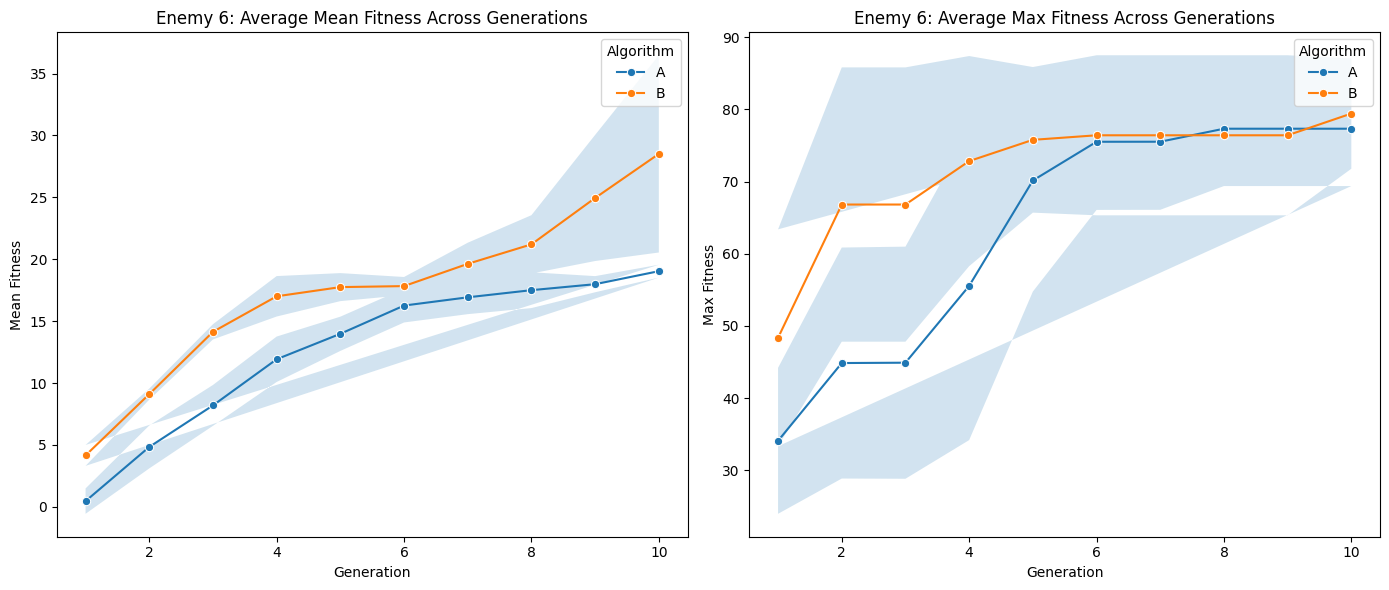

In [18]:
plt.figure(figsize=(14, 6))

# Subset data for the current enemy
data_enemy = grouped[grouped['Enemy'] == enemy]

# Plot Mean Fitness
plt.subplot(1, 2, 1)
sns.lineplot(data=data_enemy, x='Generation', y='mean_fitness_mean', hue='Algorithm', marker='o')
plt.fill_between(
	data_enemy['Generation'],
	data_enemy['mean_fitness_mean'] - data_enemy['mean_fitness_std'],
	data_enemy['mean_fitness_mean'] + data_enemy['mean_fitness_std'],
	alpha=0.2
)
plt.title(f'Enemy {enemy}: Average Mean Fitness Across Generations')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.legend(title='Algorithm')

# Plot Max Fitness
plt.subplot(1, 2, 2)
sns.lineplot(data=data_enemy, x='Generation', y='max_fitness_mean', hue='Algorithm', marker='o')
plt.fill_between(
	data_enemy['Generation'],
	data_enemy['max_fitness_mean'] - data_enemy['max_fitness_std'],
	data_enemy['max_fitness_mean'] + data_enemy['max_fitness_std'],
	alpha=0.2
)
plt.title(f'Enemy {enemy}: Average Max Fitness Across Generations')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.legend(title='Algorithm')

plt.tight_layout()
plt.show()


# TODO: Run the best solution on 2 other enemies

# TODO: Fix Gain


In [20]:
def calculate_gain(solution, enemy, experiment_name, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    
    n_hidden_neurons_1 = 10
    n_hidden_neurons_2 = 5
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=[enemy],
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False
    )
    
    gains = []
    for _ in range(num_tests):
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    return gains

In [21]:
# Initialize data storage for gains
gains_data = {
	'Algorithm': [],
	'Enemy': [],
	'Run': [],
	'Gain': []
}

# Collect Gains for Best Solutions
for index, row in df_best_solutions.iterrows():
	algo = row['Algorithm']
	enemy = row['Enemy']
	run = row['Run']
	solution = row['Best Solution']
	
	
	# Define a unique experiment name for gain calculation
	experiment_name_gain = f'gains_{algo}_enemy_{enemy}_run_{run}'
	
	# Calculate gains
	gains = calculate_gain(solution, enemy, experiment_name_gain, num_tests=5)
	
	for gain in gains:
		gains_data['Algorithm'].append(algo)
		gains_data['Enemy'].append(enemy)
		gains_data['Run'].append(run)
		gains_data['Gain'].append(gain)

# Convert to DataFrame
df_gains = pd.DataFrame(gains_data)

# Display the first few rows of the gains data
df_gains.head()


MESSAGE: Pygame initialized for simulation.
Gain: 1.0000
Gain: 1.0000
Gain: 1.0000
Gain: 1.0000
Gain: 1.0000

MESSAGE: Pygame initialized for simulation.
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000

MESSAGE: Pygame initialized for simulation.
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000

MESSAGE: Pygame initialized for simulation.
Gain: 21.4000
Gain: 21.4000
Gain: 21.4000
Gain: 21.4000
Gain: 21.4000

MESSAGE: Pygame initialized for simulation.
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000

MESSAGE: Pygame initialized for simulation.
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000
Gain: -10.0000

MESSAGE: Pygame initialized for simulation.
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000
Gain: -20.0000

MESSAGE: Pygame initialized for simulation.
Gain: 34.6000
Gain: 34.6000
Gain: 34.6000
Gain: 34.6000
Gain: 34.6000


,Algorithm,Enemy,Run,Gain
0,A,6,1,1.0
1,A,6,1,1.0
2,A,6,1,1.0
3,A,6,1,1.0
4,A,6,1,1.0


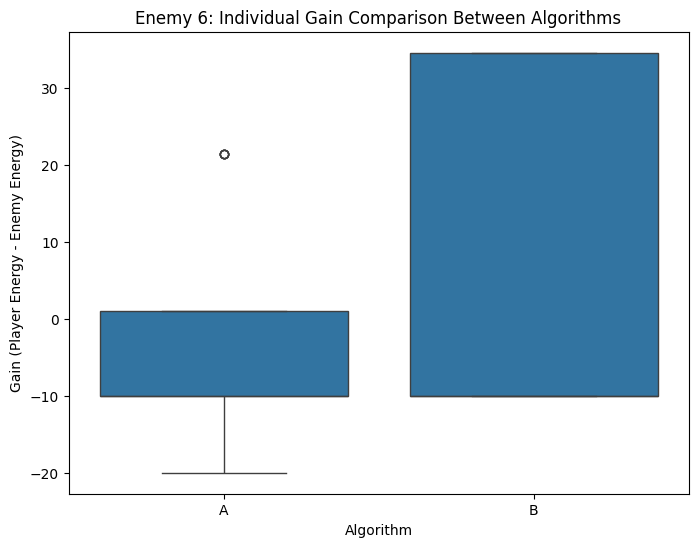

In [22]:

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_gains[(df_gains['Enemy'] == enemy)], x='Algorithm', y='Gain')
plt.title(f'Enemy {enemy}: Individual Gain Comparison Between Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Gain (Player Energy - Enemy Energy)')
plt.show()

In [23]:
# Compute mean gain per run for each algorithm and enemy
mean_gains = df_gains.groupby(['Algorithm', 'Enemy', 'Run']).agg(
    mean_gain=('Gain', 'mean')
).reset_index()

In [24]:

# Extract mean gains for each algorithm
gains_a = mean_gains[(mean_gains['Enemy'] == enemy) & (mean_gains['Algorithm'] == 'A')]['mean_gain']
gains_b = mean_gains[(mean_gains['Enemy'] == enemy) & (mean_gains['Algorithm'] == 'B')]['mean_gain']

# Perform t-test
t_stat, p_val_t = ttest_ind(gains_a, gains_b, equal_var=False)

# Perform Mann-Whitney U test
u_stat, p_val_u = mannwhitneyu(gains_a, gains_b, alternative='two-sided')

print(f"\nStatistical Test Results for Enemy {enemy}:")
print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_val_t:.4f}")
print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_val_u:.4f}")

if p_val_t < 0.05:
	print("Result: Significant difference in mean gains (t-test).")
else:
	print("Result: No significant difference in mean gains (t-test).")
	
if p_val_u < 0.05:
	print("Result: Significant difference in mean gains (Mann-Whitney U test).")
else:
	print("Result: No significant difference in mean gains (Mann-Whitney U test).")



Statistical Test Results for Enemy 6:
T-test: t-statistic = -0.6696, p-value = 0.6200
Mann-Whitney U test: U-statistic = 2.0, p-value = 1.0000
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).
